# Network Algorithms Homework
By Asif Mammadov, Rustam Aliyev, Maryam Babayeva

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from geopy import distance
from geopy import Point
import utils
import shortest_path

In [2]:
# Obtain the data
airports = pd.read_csv('airports.csv')
routes = pd.read_csv('routes.csv')

In [3]:
# returns all the information about an airport by its IATA
def airport_info(data_airports, iata):
    return data_airports.loc[data_airports['IATA'] == iata]
def airport_name_from_iata(data_airports, iata):
    return data_airports.loc[data_airports['IATA'] == iata]['Name'].iat[0]

In [4]:
def filter_na(df, column):
    na_rows = df[column].str.len() < 3
    return df[~na_rows]

# Filter the N/A values in the data
filtered_airports = filter_na(airports, "IATA")
filtered_routes = filter_na(routes, 'Source airport ID')
filtered_routes = filter_na(filtered_routes, 'Destination airport ID')

# change the datatype in routes
filtered_routes['Source airport ID'] = filtered_routes['Source airport ID'].astype('int64')
filtered_routes['Destination airport ID'] = filtered_routes['Destination airport ID'].astype('int64')

In [5]:
def get_countries_of(region):
    if (region == 'Europe'):
        import requests
        response = requests.get("https://restcountries.com/v3.1/region/europe")
        l = response.json()
        europe = []
        for i in range(len(l)):
            europe.append(l[i]['name']['common'])
        return europe
    # future support for other regions

def filter_to_europe(df, attr):
    europe = get_countries_of('Europe')
    return df[df[attr].isin(europe)]

def filter_to_countries(df, countries):
    return df[df['Country'].isin(countries)]

# Choose only one region (europe in our example)
filtered_european_airports = filter_to_europe(filtered_airports, 'Country')

# Choose only one country (France in our example)
filtered_some_airports = filter_to_countries(filtered_airports, ['France'])


In [6]:
# Filter routes according to filtered airports
airport_id = filtered_european_airports['Airport ID']
filtered_european_routes = filtered_routes[filtered_routes['Source airport ID'].isin(airport_id) & filtered_routes['Destination airport ID'].isin(airport_id)]

airport_id = filtered_some_airports['Airport ID']
filtered_some_routes = filtered_routes[filtered_routes['Source airport ID'].isin(airport_id) & filtered_routes['Destination airport ID'].isin(airport_id)]

In [7]:
def get_coords(airport_id, airports):
    airport = airports.loc[airports['Airport ID'] == airport_id]
    return (airport['Latitude'], airport['Longitude'])

In [8]:
def add_coords_to_routes(routes, airports):
    pd.options.mode.chained_assignment = None
    sources_latitude = []
    sources_longitude = []
    destinations_latitude = []
    destinations_longitude = []

    for ind in routes.index:
        source_coords = get_coords(routes.loc[ind, 'Source airport ID'], airports)
        sources_latitude.append(source_coords[0].to_string().split(' ')[-1])
        sources_longitude.append(source_coords[1].to_string().split(' ')[-1])

        destination_coords = get_coords(routes.loc[ind, 'Destination airport ID'], airports)
        destinations_latitude.append(destination_coords[0].to_string().split(' ')[-1])
        destinations_longitude.append(destination_coords[1].to_string().split(' ')[-1])
    
    routes.loc[:, 'Source latitude'] = sources_latitude
    routes.loc[:, 'Source longitude'] = sources_longitude
    routes.loc[:, 'Destination latitude'] = destinations_latitude
    routes.loc[:, 'Destination longitude'] = destinations_longitude

    return routes

In [9]:
# modified_routes = add_coords_to_routes(filtered_european_routes, filtered_european_airports)

modified_some_routes = add_coords_to_routes(filtered_some_routes, filtered_some_airports)

In [10]:
def get_dists(routes):
    return routes.apply(
        lambda row:
            distance.distance(
                (row['Source latitude'], row['Source longitude']),
                (row['Destination latitude'], row['Destination longitude'])
            ).km,
        axis = 1
    )

In [11]:
# dist = get_dists(modified_routes)
dist_some = get_dists(modified_some_routes)

# array dist is an array of all the distances between sources and destinations that should be created and filled by Rustam
# once it's filled a new data frame with the Source, Destination and Distance values will be created
# distances = pd.Series(dist, name = 'Distance')
distances_some = pd.Series(dist_some, name = 'Distance')
# data = [filtered_european_routes['Source airport'].reset_index(drop=True),filtered_european_routes['Destination airport'].reset_index(drop=True), distances.reset_index(drop=True)]
data_some = [filtered_some_routes['Source airport'].reset_index(drop=True),filtered_some_routes['Destination airport'].reset_index(drop=True), distances_some.reset_index(drop=True)]

# new DataFrame only with the Source, Destination and Distance values
# df = pd.DataFrame(data).T
df_some = pd.DataFrame(data_some).T
# print(df)

['AGF', 'AJA', 'ANG', 'AUR', 'AVN', 'BES', 'BIA', 'BIQ', 'BOD', 'BSL', 'BVA', 'BVE', 'BZR', 'CDG', 'CFE', 'CFR', 'CLY', 'DCM', 'DIJ', 'EBU', 'EGC', 'ETZ', 'FSC', 'LAI', 'LDE', 'LEH', 'LIG', 'LIL', 'LPY', 'LRH', 'LRT', 'LYS', 'MPL', 'MRS', 'NCE', 'NTE', 'ORY', 'PGF', 'PGX', 'PIS', 'PUF', 'RDZ', 'RNS', 'SXB', 'TLN', 'TLS', 'TUF', 'UIP']


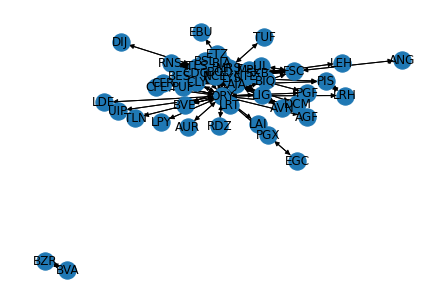

In [12]:
#Creating a graph from the filtered european routes
# G = nx.from_pandas_edgelist(df, source='Source airport', target='Destination airport', edge_attr=True, create_using=nx.DiGraph)
G = nx.from_pandas_edgelist(df_some, source='Source airport', target='Destination airport', edge_attr=True, create_using=nx.DiGraph)
nx.draw(G, with_labels=True)

print(sorted(G.nodes()))

In [13]:
# Network Density
network_densit = utils.network_density(G)
print("Network Density = ", network_densit)

Network Density =  0.2765957446808511


In [14]:
# Network Diameter
m_path = utils.max_path(utils.get_all_pathes(G, 'Distance'))
network_diam = utils.network_diameter(G, 'Distance')
print("Network Diameter = %d\nMax path : %s" % (network_diam, m_path))

In [ ]:
# Network Average Path Length
napl = utils.network_average_path_length(G, 'Distance')
print("Network Average Path Length = %.2f" % napl)

Network Average Path Length = 3.19


In [ ]:

#Closeness Centrality of Airport
closeness_c = {}
for airport in G.nodes():
  closeness_c[airport] = round(utils.closeness_centrality(G, airport, 'Distance'), 2)
# print("Closeness Centrality of Frankfurt Airport: ", cc_FRA)
print(closeness_c)

max_closeness = max(closeness_c.keys(), key=(lambda k: closeness_c[k]))
min_closeness = min(closeness_c.keys(), key=(lambda k: closeness_c[k]))

print("Max closeness: %.2f %s %s" % (closeness_c[max_closeness], max_closeness,airport_name_from_iata(filtered_european_airports, max_closeness)))
print("Min closeness: %.2f %s %s" % (closeness_c[min_closeness], min_closeness,airport_name_from_iata(filtered_european_airports, min_closeness)))
print("Average closeness: %.2f" % (sum(value for value in closeness_c.values())/len(closeness_c.values())))
# print("Min closeness: %s %s" % )

{'AGF': 2.38, 'DCM': 2.15, 'ORY': 1.21, 'AJA': 1.56, 'BVE': 2.17, 'PIS': 2.38, 'AUR': 2.12, 'BES': 1.81, 'LYS': 1.44, 'NCE': 1.54, 'BIA': 1.79, 'LIL': 1.98, 'BIQ': 1.83, 'BOD': 1.62, 'NTE': 1.6, 'SXB': 1.69, 'CFE': 1.94, 'CFR': 2.02, 'CLY': 2.06, 'ETZ': 2.17, 'FSC': 2.02, 'LAI': 2.12, 'LDE': 2.12, 'MPL': 1.9, 'TLS': 1.65, 'LRH': 2.44, 'LRT': 2.08, 'MRS': 1.58, 'PUF': 1.92, 'RNS': 2.15, 'PGF': 2.04, 'RDZ': 2.12, 'UIP': 2.12, 'CDG': 1.9, 'EBU': 2.71, 'BSL': 2.19, 'TLN': 2.12, 'AVN': 2.6, 'LIG': 1.9, 'BVA': 0.02, 'BZR': 0.02, 'TUF': 2.5, 'ANG': 2.94, 'DIJ': 2.56, 'EGC': 3.0, 'PGX': 2.08, 'LEH': 2.35, 'LPY': 2.12}
Max closeness: 3.00 EGC Bergerac-Roumanière Airport
Min closeness: 0.02 BVA Paris Beauvais Tillé Airport
Average closeness: 1.97


We conclude that Bergerac-Roumanière Airport is the farthest and Paris Beauvais Tillé Airport is the closest among the airports in France.

In [ ]:

degrees = {}
for airport in G.nodes():
  degree = utils.degree(G, airport)
  inflow = utils.degree_inflow(G, airport)
  outflow = utils.degree_outflow(G, airport)
  degrees[airport] = [degree, inflow, outflow]

print(degrees, end='\n\n')

max_degree = max(degrees.keys(), key=(lambda k: degrees[k][0]))
min_degree = min(degrees.keys(), key=(lambda k: degrees[k][0]))
print("Max degree: %d %s %s" % (degrees[max_degree][0], max_degree,airport_name_from_iata(filtered_european_airports, max_degree)))
print("Min degree: %d %s %s" % (degrees[min_degree][0], min_degree,airport_name_from_iata(filtered_european_airports, min_degree)))
print("Average degree: ", sum(value[0] for value in degrees.values())/len(degrees.values()))

max_inflow = max(degrees.keys(), key=(lambda k: degrees[k][1]))
min_inflow = min(degrees.keys(), key=(lambda k: degrees[k][1]))
print("Max inflow: %d %s %s" % (degrees[max_inflow][1], max_inflow,airport_name_from_iata(filtered_european_airports, max_inflow)))
print("Min inflow: %d %s %s" % (degrees[min_inflow][1], min_inflow,airport_name_from_iata(filtered_european_airports, min_inflow)))
print("Average inflow: ", sum(value[1] for value in degrees.values())/len(degrees.values()))

max_outflow = max(degrees.keys(), key=(lambda k: degrees[k][2]))
min_outflow = min(degrees.keys(), key=(lambda k: degrees[k][2]))
print("Max outflow: %d %s %s" % (degrees[max_outflow][2], max_outflow,airport_name_from_iata(filtered_european_airports, max_outflow)))
print("Min outflow: %d %s %s" % (degrees[min_outflow][2], min_outflow,airport_name_from_iata(filtered_european_airports, min_outflow)))
print("Average outflow: ", sum(value[2] for value in degrees.values())/len(degrees.values()))


{'AGF': [4, 2, 2], 'DCM': [6, 3, 3], 'ORY': [64, 32, 32], 'AJA': [36, 18, 18], 'BVE': [4, 2, 2], 'PIS': [6, 3, 3], 'AUR': [2, 1, 1], 'BES': [16, 8, 8], 'LYS': [46, 23, 23], 'NCE': [40, 20, 20], 'BIA': [24, 12, 12], 'LIL': [24, 12, 12], 'BIQ': [14, 7, 7], 'BOD': [30, 15, 15], 'NTE': [32, 16, 16], 'SXB': [24, 12, 12], 'CFE': [8, 4, 4], 'CFR': [8, 4, 4], 'CLY': [12, 6, 6], 'ETZ': [8, 4, 4], 'FSC': [14, 7, 7], 'LAI': [2, 1, 1], 'LDE': [2, 1, 1], 'MPL': [16, 8, 8], 'TLS': [28, 14, 14], 'LRH': [4, 2, 2], 'LRT': [4, 2, 2], 'MRS': [36, 18, 18], 'PUF': [8, 4, 4], 'RNS': [12, 6, 6], 'PGF': [4, 2, 2], 'RDZ': [2, 1, 1], 'UIP': [2, 1, 1], 'CDG': [32, 16, 16], 'EBU': [2, 1, 1], 'BSL': [14, 7, 7], 'TLN': [2, 1, 1], 'AVN': [4, 2, 2], 'LIG': [8, 4, 4], 'BVA': [2, 1, 1], 'BZR': [2, 1, 1], 'TUF': [2, 1, 1], 'ANG': [2, 1, 1], 'DIJ': [2, 1, 1], 'EGC': [2, 1, 1], 'PGX': [4, 2, 2], 'LEH': [2, 1, 1], 'LPY': [2, 1, 1]}

Max degree: 64 ORY Paris-Orly Airport
Min degree: 2 AUR Aurillac Airport
Average degree:  1

In [ ]:

#Between Centrality of Airport
between_c = {}
pathes = utils.get_all_pathes(G, 'Distance')

for airport in G.nodes():
  between_c[airport] = utils.between_centrality(G, airport, pathes)

print(between_c)
total_between = sum(value for value in between_c.values())
length_between = len(between_c.values())
max_between = max(between_c.keys(), key=(lambda k: between_c[k]))
min_between = min(between_c.keys(), key=(lambda k: between_c[k]))


print("Max betweenness: %d %s %s | %.2f percent of all pathes" % (between_c[max_between], max_between,airport_name_from_iata(filtered_european_airports, max_between), between_c[max_between]/length_between))
print("Min betweenness: %d %s %s | %.2f percent of all pathes" % (between_c[min_between], min_between,airport_name_from_iata(filtered_european_airports, min_between), between_c[min_between]/length_between))
print("Average betweenness: %.2f" % (total_between/length_between))


{'AGF': 90, 'DCM': 112, 'ORY': 1094, 'AJA': 176, 'BVE': 90, 'PIS': 132, 'AUR': 90, 'BES': 90, 'LYS': 454, 'NCE': 284, 'BIA': 178, 'LIL': 90, 'BIQ': 90, 'BOD': 128, 'NTE': 140, 'SXB': 120, 'CFE': 118, 'CFR': 90, 'CLY': 98, 'ETZ': 90, 'FSC': 178, 'LAI': 90, 'LDE': 90, 'MPL': 90, 'TLS': 178, 'LRH': 126, 'LRT': 90, 'MRS': 236, 'PUF': 90, 'RNS': 90, 'PGF': 90, 'RDZ': 90, 'UIP': 90, 'CDG': 108, 'EBU': 90, 'BSL': 90, 'TLN': 90, 'AVN': 92, 'LIG': 146, 'BVA': 2, 'BZR': 2, 'TUF': 90, 'ANG': 90, 'DIJ': 90, 'EGC': 90, 'PGX': 178, 'LEH': 90, 'LPY': 90}
Max betweenness: 1094 ORY Paris-Orly Airport | 22.79 percent of all pathes
Min betweenness: 2 BVA Paris Beauvais Tillé Airport | 0.04 percent of all pathes
Average betweenness: 137.92


As we can see the Paris-Orly Airport is the most common intermediate airport, it was occured in 1094 pathes which makes up 23% of all pathes.
Meanwhile Paris Beauvasi Tille Airport only occurs in 2 pathes.


In [ ]:
# shortest pathes were used inside previous functions like closeness centrality
# here is an example of Dijkstra's shortest path

print('From %s -> %s : ' % ('EGC', 'EBU'), shortest_path.dijkstra(G, 'EGC', 'EBU', 'Distance'))
print('From %s -> %s : ' % ('LRH', 'PGF'), shortest_path.dijkstra(G, 'LRH', 'PGF', 'Distance'))


From EGC -> EBU :  ['EGC', 'PGX', 'ORY', 'BIA', 'EBU']
From LRH -> PGF :  ['LRH', 'ORY', 'PGF']
